*1. Продумать структуру базы данных и отрисовать в редакторе.*

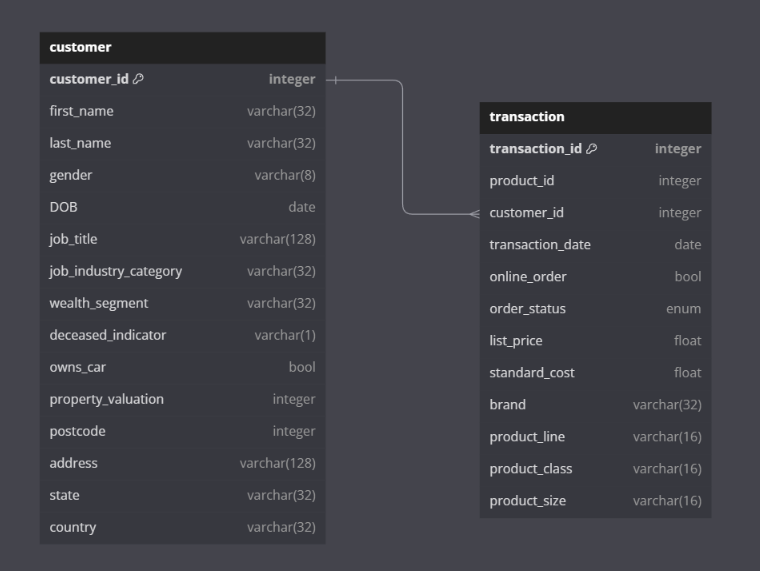

*2. Нормализовать базу данных (1НФ — 3НФ), описав, к какой нормальной форме приводится таблица и почему таблица в этой нормальной форме изначально не находилась.*

Таблица уже находится в первой и второй нормальной форме, так как каждый атрибут зависит от первичного ключа и нет частичных зависимостей.

Требования 3НФ:

1. Таблица должна быть во 2НФ.

2. Все атрибуты должны быть неприводимо зависимы только от первичного ключа, без транзитивных зависимостей.

В таблице customer можно заметить, что поля, связанные с адресом (address, postcode, state, country), могут быть выделены в отдельную таблицу.

Теоретически, у заказчика может быть много адресов, как и несколько заказчиков могут иметь один адрес. Поэтому используем связь многие-ко-многим.

Удалим транзитивную зависимость.

В таблице transaction, поля, такие как brand, product_line, product_size, list_price, и standard_cost могут быть зависимы не напрямую от transaction_id, а от product_id. Это означает, что эти поля лучше вынести в отдельную таблицу product.

product_id не определяет продукт однозначно, есть разные товары с одним product_id, но разными брендами. Поэтому будем использовать составной ключ
(product_id, brand).

После нормализации получаем следующую диаграмму:

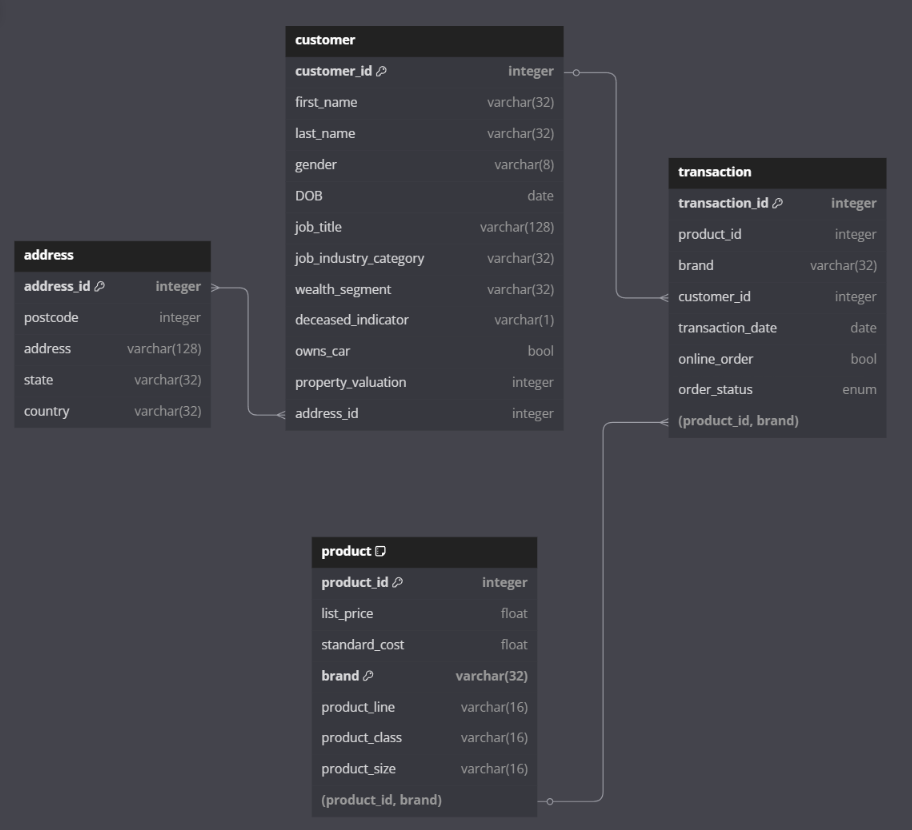

*3. Создать все таблицы в DBeaver, указав первичные ключи к таблицам, правильные типы данных, могут ли поля быть пустыми или нет (использовать команду CREATE TABLE).*



```
BEGIN;

-- Создание пользовательского типа order_status
CREATE TYPE order_status AS ENUM ('Approved', 'Cancelled');

-- Создание таблицы address
CREATE TABLE address (
    address_id INTEGER PRIMARY KEY,
    address VARCHAR(128) NOT NULL,
    postcode INTEGER NOT NULL,
    state VARCHAR(32) NOT NULL,
    country VARCHAR(32) NOT NULL
);

-- Создание таблицы product
CREATE TABLE product (
    product_id INTEGER,
    brand VARCHAR(32),
    product_line VARCHAR(16),
    product_class VARCHAR(16),
    product_size VARCHAR(16),
    list_price FLOAT,
    standard_cost FLOAT,
    PRIMARY KEY (product_id, brand)
);

-- Создание таблицы customer
CREATE TABLE customer (
    customer_id INTEGER PRIMARY KEY,
    first_name VARCHAR(32) NOT NULL,
    last_name VARCHAR(32),
    gender VARCHAR(32),
    DOB DATE,
    job_title VARCHAR(128),
    job_industry_category VARCHAR(32),
    wealth_segment VARCHAR(32),
    deceased_indicator VARCHAR(1),
    owns_car BOOLEAN,
    address_id INTEGER NOT NULL,
    property_valuation INTEGER,
    FOREIGN KEY (address_id) REFERENCES address(address_id)
);

-- Создание таблицы transaction
CREATE TABLE transaction (
    transaction_id INTEGER PRIMARY KEY,
    product_id INTEGER NOT NULL,
    customer_id INTEGER NOT NULL,
    transaction_date DATE NOT NULL,
    online_order BOOLEAN,
    order_status order_status,  -- Используем тип order_status
    FOREIGN KEY (product_id, brand) REFERENCES product(product_id, brand),
    FOREIGN KEY (customer_id) REFERENCES customer(customer_id)
);

COMMIT;
```



4. Загрузить данные в таблицы в соответствии с созданной структурой (использовать команду INSERT INTO или загрузить файлы, используя возможности инструмента DBeaver; в случае загрузки файлами приложить скрины, что данные действительно были залиты).

Загрузим данные в таблицы address и product через импорт dbeaver.

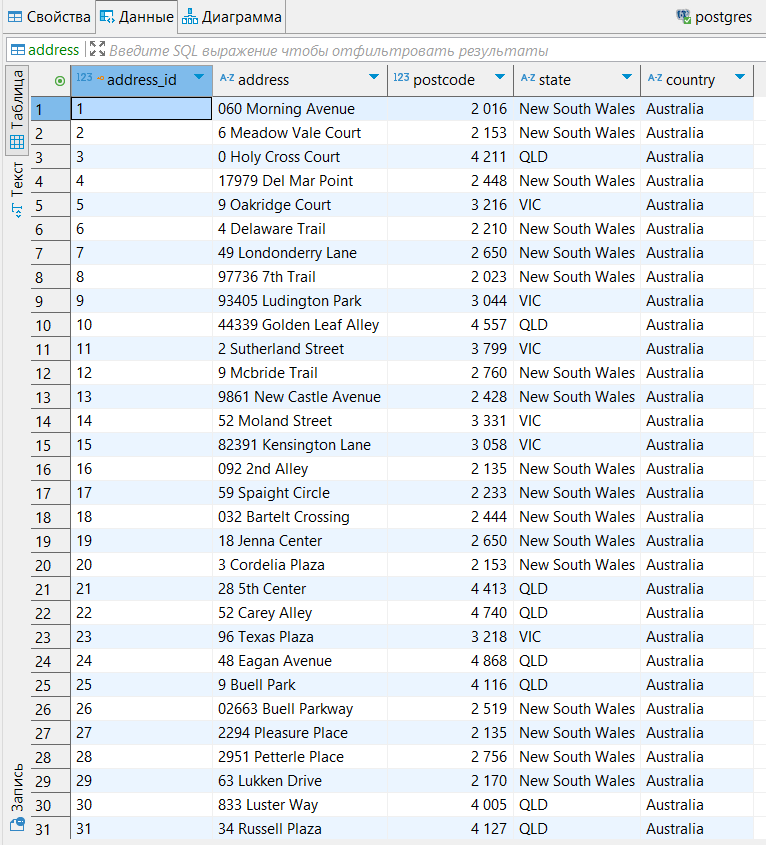

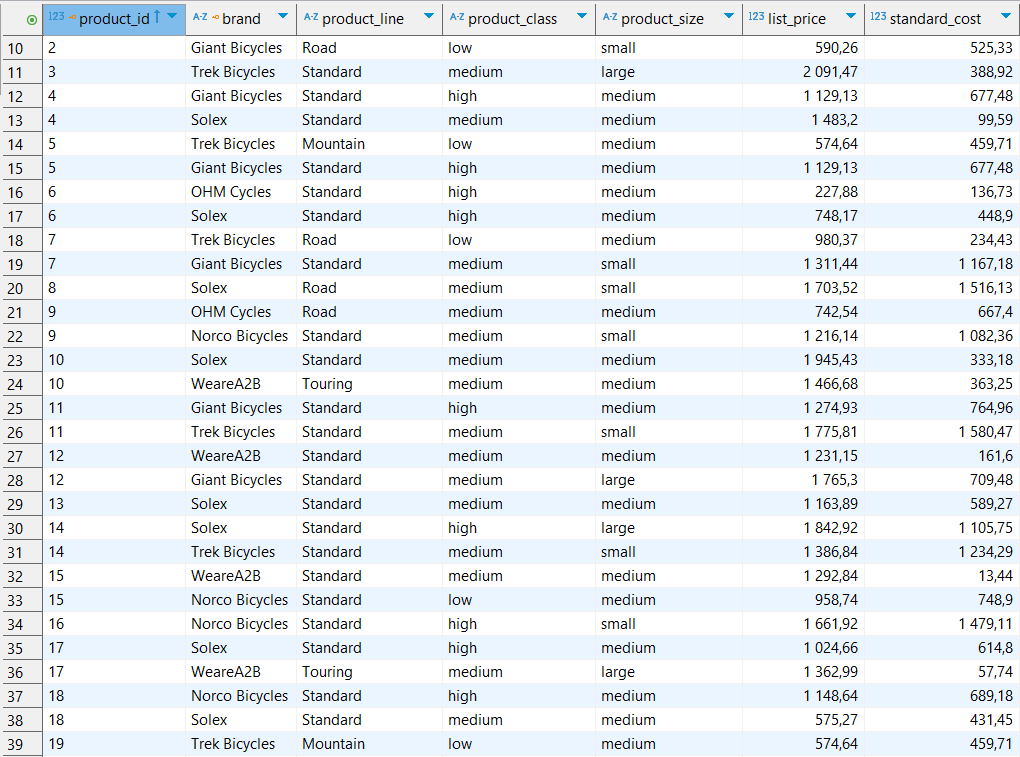

Таблицы customer и transaction заполним при помощи скриптов.



```
INSERT INTO customer (customer_id, first_name, last_name, gender, dob, job_title, job_industry_category, wealth_segment, deceased_indicator, owns_car, address_id, property_valuation)
SELECT
    cf.customer_id,
    cf.first_name,
    cf.last_name,
    cf.gender,
    TO_DATE(cf."DOB", 'YYYY-MM-DD') AS dob,  -- Преобразуем строку в дату
    cf.job_title,
    cf.job_industry_category,
    cf.wealth_segment,
    cf.deceased_indicator,
    cf.owns_car::boolean,  -- Преобразуем строку в boolean
    a.address_id,
    cf.property_valuation
FROM
    customer_full cf
JOIN
    address a ON cf.address = a.address AND cf.postcode = a.postcode AND cf.state = a.state AND cf.country = a.country;
```



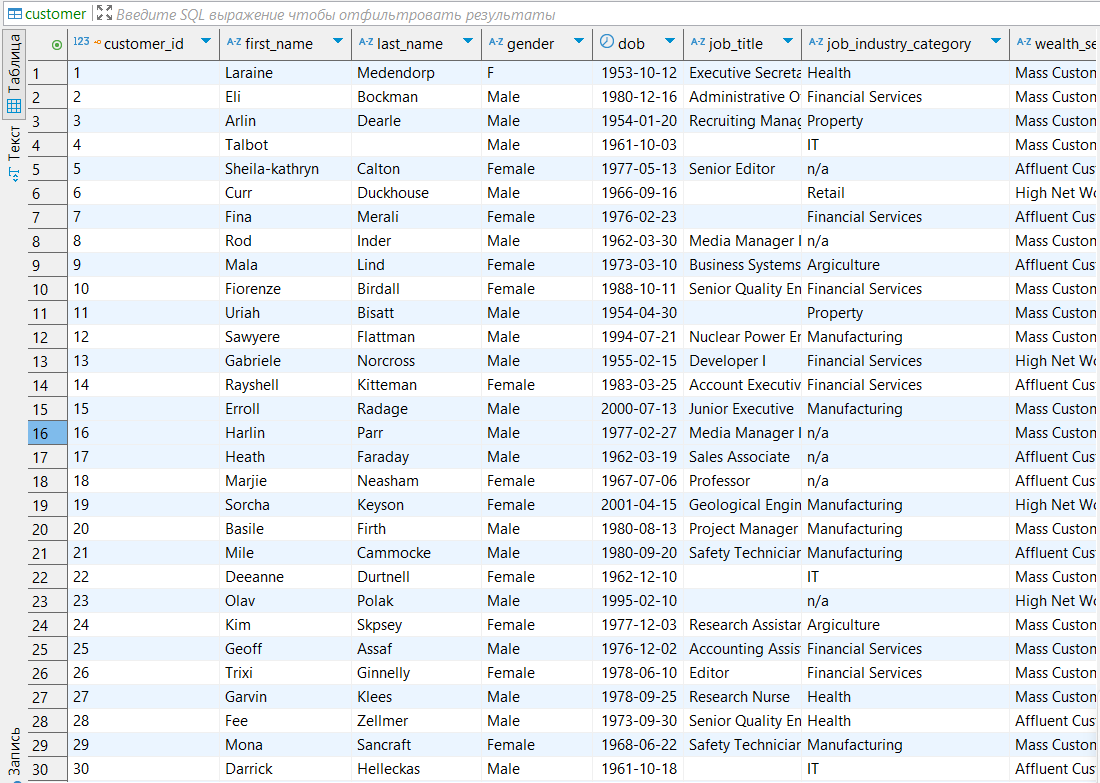



```
INSERT INTO "transaction" (
    transaction_id,
    product_id,
    customer_id,
    transaction_date,
    online_order,
    order_status
)
SELECT
    tf.transaction_id,
    p.product_id,
    c.customer_id,
    TO_DATE(tf.transaction_date, 'YYYY-MM-DD') AS transaction_date,  -- Преобразуем строку в дату
    tf.online_order,
    tf.order_status::public.order_status  -- Приводим к типу order_status
FROM
    public.transaction_full tf
JOIN
    public.product p ON tf.product_id = p.product_id AND tf.brand = p.brand
JOIN
    public.customer c ON tf.customer_id = c.customer_id;
```



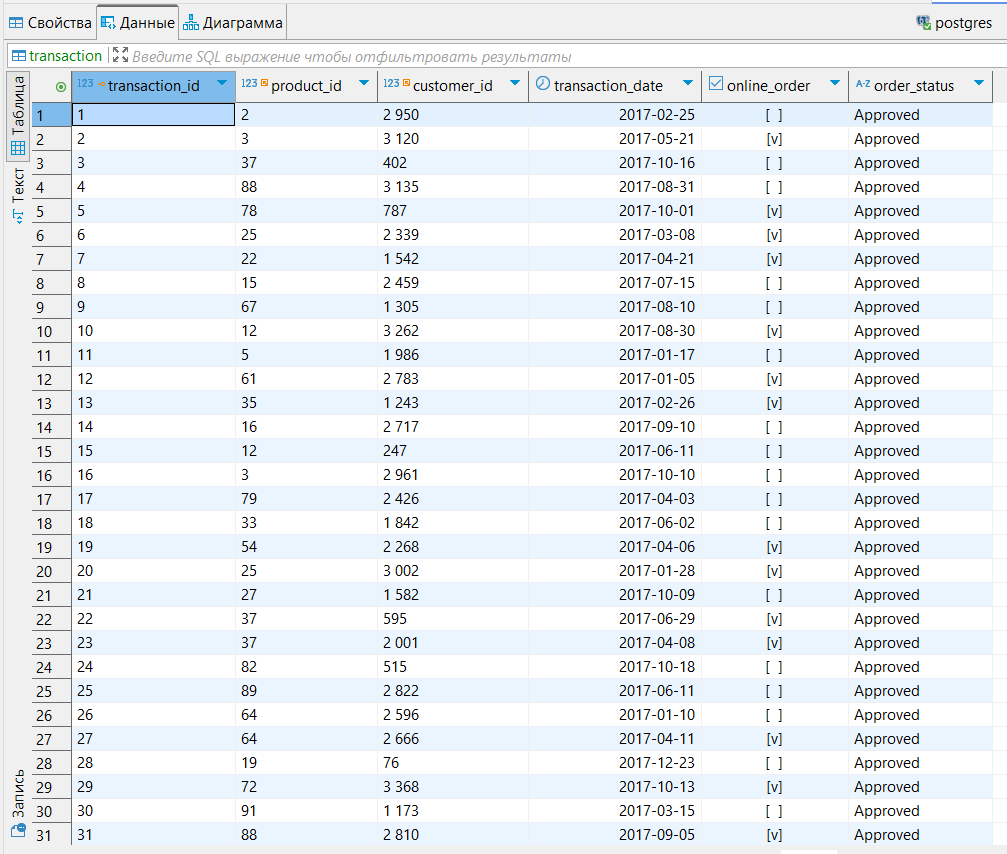